In [7]:
import os
import warnings
from pathlib import Path
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import string
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder,OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
# import seaborn as sns
from IPython.display import display
from pandas.api.types import CategoricalDtype

# from category_encoders import MEstimateEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import KFold, cross_val_score
from xgboost import XGBRegressor

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

# Mute warnings
warnings.filterwarnings('ignore')


# Read the data
X_full = pd.read_csv('train.csv', index_col = 'PassengerId')
# Remove rows with missing target, separate target from predictors
X_full.dropna(axis=0, subset=['Survived'], inplace=True)
#terget encoding
#Creating new family_size column 
X_full['Family_Size'] = X_full['SibSp']+X_full['Parch']
X_full['Survived in group'] = X_full.groupby('Family_Size')['Survived'].transform('mean')
func = dict(zip(X_full['Family_Size'].unique(), X_full['Survived in group'].unique()))
func[7] = 0
func[10] = 0

y = X_full.Survived
X_full.drop(['Survived'], axis=1, inplace=True)

def substrings_in_string(big_string, substrings):
    for substring in substrings:
        if str.find(big_string, substring) != -1:
            return substring
    print (big_string)
    return np.nan

title_list=['Mrs', 'Mr', 'Master', 'Miss', 'Major', 'Rev',
                    'Dr', 'Ms', 'Mlle','Col', 'Capt', 'Mme', 'Countess',
                    'Don', 'Jonkheer']
#Now that I have them, I recombine them to the four categories.

X_full['Title'] = X_full['Name'].map(lambda x: substrings_in_string(x, title_list))
 
#replacing all titles with mr, mrs, miss, master
def replace_titles(x):
    title=x['Title']
    if title in ['Don', 'Major', 'Capt', 'Jonkheer', 'Rev', 'Col']:
        return 'Mr'
    elif title in ['Countess', 'Mme']:
        return 'Mrs'
    elif title in ['Mlle', 'Ms']:
        return 'Miss'
    elif title =='Dr':
        if x['Sex']=='Male':
            return 'Mr'
        else:
            return 'Mrs'
    else:
        return title
    
X_full['Title']=X_full.apply(replace_titles, axis=1)

X_full['Embarked'] = X_full['Embarked'].fillna('Unknown')
#Turning cabin number into Deck
cabin_list = ['A', 'B', 'C', 'D', 'E', 'F', 'T', 'G', 'Unknown']
X_full['Cabin'] = X_full['Cabin'].fillna('Unknown')
X_full['Deck'] = X_full['Cabin'].map(lambda x: substrings_in_string(x, cabin_list))

X_full['Age*Class']=X_full['Age']*X_full['Pclass']

X_full['Fare_Per_Person']=X_full['Fare']/(X_full['Family_Size']+1)



# Break off validation set from training data
X_train_full, X_valid_full, y_train, y_valid = train_test_split(X_full, y, 
                                                                train_size=0.8, test_size=0.2,
                                                                random_state=0)

categorical_cols = ['Sex', 'Embarked' , 'Pclass',  'SibSp', 'Parch', 'Title','Deck','Family_Size']

# Select numerical columns
numerical_cols = ['Age','Fare','Age*Class','Fare_Per_Person','Survived in group']

# Keep selected columns only
my_cols = categorical_cols + numerical_cols
X_train = X_train_full[my_cols].copy()
X_valid = X_valid_full[my_cols].copy()

In [8]:
def encode(df):
    # Nominal categories
    for name in categorical_cols:
        df[name] = df[name].astype("category")
        # Add a None category for missing values
        if "None" not in df[name].cat.categories:
            df[name].cat.add_categories("None", inplace=True)
    # Ordinal categories
#     for name, levels in ordered_levels.items():
#         df[name] = df[name].astype(CategoricalDtype(levels,
#                                                     ordered=True))
    return df
encode(X_train)

,Sex,Embarked,Pclass,SibSp,Parch,Title,Deck,Family_Size,Age,Fare,Age*Class,Fare_Per_Person,Survived in group
PassengerId,,,,,,,,,,,,,
141,female,C,3,0,2,Mrs,Unknown,2,NaN,15.2458,NaN,5.081933,0.578431
440,male,S,2,0,0,Mr,Unknown,0,31.0,10.5000,62.0,10.500000,0.303538
818,male,C,2,1,1,Mr,Unknown,2,31.0,37.0042,62.0,12.334733,0.578431
379,male,C,3,0,0,Mr,Unknown,0,20.0,4.0125,60.0,4.012500,0.303538
492,male,S,3,0,0,Mr,Unknown,0,21.0,7.2500,63.0,7.250000,0.303538
...,...,...,...,...,...,...,...,...,...,...,...,...,...
836,female,C,1,1,1,Miss,E,2,39.0,83.1583,39.0,27.719433,0.578431
193,female,S,3,1,0,Miss,Unknown,1,19.0,7.8542,57.0,3.927100,0.552795
630,male,Q,3,0,0,Mr,Unknown,0,NaN,7.7333,NaN,7.733300,0.303538


In [10]:
from sklearn.feature_selection import mutual_info_regression
def make_mi_scores(X, y):
    X = X.copy()
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()
    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores


def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

In [12]:
scores = make_mi_scores(pd.concat([X_train[numerical_cols].fillna(0),X_train[categorical_cols]],axis = 1), y_train)

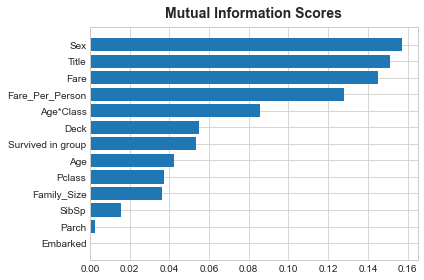

In [13]:
plot_mi_scores(scores)

In [14]:
X_train.drop(['Embarked'],axis=1, inplace=True )
categorical_cols.remove('Embarked')

In [15]:
# Preprocessing for numerical data
numerical_transformer = SimpleImputer(strategy='mean')

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('orden', OrdinalEncoder(handle_unknown='use_encoded_value',unknown_value = 9))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Define model
model = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=1)

# Bundle preprocessing and modeling code in a pipeline
my_pip = Pipeline(steps=[('preprocessor', preprocessor),
                      ('model', model)
                     ])

# Preprocessing of training data, fit model 
my_pip.fit(X_train, y_train)

# Preprocessing of validation data, get predictions
preds = my_pip.predict(X_valid)

print('auc score:', roc_auc_score(y_valid, preds))

auc score: 0.8015151515151515
